In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Library

In [ ]:
pip install transformers==4.3.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.0 MB/s 
     |████████████████████████████████| 3.3 MB 45.2 MB/s 
     |████████████████████████████████| 880 kB 57.8 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=8bf5fb557e22803ca67faf9d3f92079f8ab367a4b835ed2c9985210898de1a1e
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses


In [ ]:
pip install vncorenlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.6 MB 5.1 MB/s 
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-py3-none-any.whl size=2645951 sha256=482d46dd3ca89f86539a48b4e71ef8748ab5836c9b983be4284335d6f37bd84d
  Stored in directory: /root/.cache/pip/wheels/0c/d8/f2/d28d97379b4f6479bf51247c8dfd57fa00932fa7a74b6aab29
Successfully built vncorenlp


In [ ]:
!mkdir -p vncorenlp/models/wordsegmenter
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
!mv VnCoreNLP-1.1.1.jar vncorenlp/
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

--2022-06-11 11:43:25--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27412575 (26M) [application/octet-stream]
Saving to: ‘VnCoreNLP-1.1.1.jar’

VnCoreNLP-1.1.1.jar 100%[===================>]  26.14M   170MB/s    in 0.2s    

2022-06-11 11:43:25 (170 MB/s) - ‘VnCoreNLP-1.1.1.jar’ saved [27412575/27412575]

--2022-06-11 11:43:26--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting respon

#Data loader and preprocessing

In [ ]:
import pandas as pd
# load data
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ViHSD/train.csv", index_col=False)
dev = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ViHSD/dev.csv", index_col=False)
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ViHSD/test.csv", index_col=False)

train.reset_index(drop=True)

print(len(train))
print(len(dev))
print(len(test))

24048
2672
6680


In [ ]:
from vncorenlp import VnCoreNLP

vncorenlp = VnCoreNLP("vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m')

In [ ]:
#pre-process
import re
import numpy as np

STOPWORDS = '/content/drive/MyDrive/Colab Notebooks/ViHSD/vietnamese-stopwords.txt'
with open(STOPWORDS, "r") as ins:
    stopwords = []
    for line in ins:
        dd = line.strip('\n')
        stopwords.append(dd)
    stopwords = set(stopwords)

def filter_stop_words(train_sentences, stop_words):
    new_sent = [word for word in train_sentences.split() if word not in stop_words]
    train_sentences = ' '.join(new_sent)
        
    return train_sentences

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

def preprocess(text, tokenized=True, lowercased=True):
    # text = ViTokenizer.tokenize(text)
    # text = ' '.join(vncorenlp.tokenize(text)[0])
    text = filter_stop_words(text, stopwords)
    text = deEmojify(text)
    text = text.lower() if lowercased else text
    if tokenized:
        pre_text = ""
        sentences = vncorenlp.tokenize(text)
        for sentence in sentences:
            pre_text += " ".join(sentence)
        text = pre_text
    return text

def pre_process_features(X, y, tokenized=True, lowercased=True):
    X = [preprocess(str(p), tokenized=tokenized, lowercased=lowercased) for p in list(X)]
    for idx, ele in enumerate(X):
        if not ele:
            np.delete(X, idx)
            np.delete(y, idx)
    return X, y

X_train = train['free_text']
y_train = train['label_id'].values

X_dev = dev['free_text']
y_dev = dev['label_id'].values

X_test = test['free_text']
y_test = test['label_id'].values

#Model


##PhoBERT

Downloading:   0%|          | 0.00/557 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['

Downloading:   0%|          | 0.00/895k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


Step,Training Loss
500,0.571100
1000,0.437900
1500,0.405100
2000,0.335200
2500,0.308100
3000,0.305000


[[5313   95  140]
 [ 213  142   89]
 [ 253   55  380]]
F1 - micro: 0.8735029940119761
F1 - macro: 0.6366498858048629
Accuracy: 0.8735029940119761


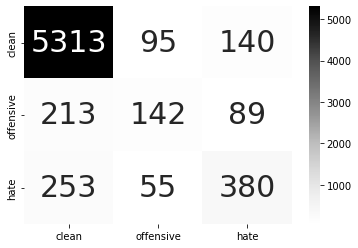

In [ ]:
# PhoBERT
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, recall_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, BertTokenizer, BertForSequenceClassification

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

train_X, train_y = pre_process_features(X_train, y_train, tokenized=True, lowercased = False)
dev_X, dev_y = pre_process_features(X_dev, y_dev, tokenized=True, lowercased = False)
test_X, test_y = pre_process_features(X_test, y_test, tokenized=True, lowercased = False)
  
model = AutoModelForSequenceClassification.from_pretrained("vinai/phobert-base", num_labels = 3)
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base",use_fast=False)

import torch

class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_encodings = tokenizer(train_X, truncation=True, padding=True, max_length=100)
dev_encodings = tokenizer(dev_X, truncation=True, padding=True, max_length=100)
test_encodings = tokenizer(test_X, truncation=True, padding=True, max_length=100)

train_dataset = BuildDataset(train_encodings, train_y)
dev_dataset = BuildDataset(dev_encodings, dev_y)
test_dataset = BuildDataset(test_encodings, test_y)

training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Colab Notebooks/ViHSD/transformer_model/phobert-v3/',          
    num_train_epochs=2,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=16,   
    warmup_steps=500,                
    weight_decay=0.01,
    no_cuda=False,
    do_eval=True
)

trainer = Trainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=dev_dataset             
)

trainer.train()
trainer.save_model("/content/drive/MyDrive/Colab Notebooks/ViHSD/transformer_model/phobert-v3/")

y_pred_classify = trainer.predict(test_dataset)

y_pred = np.argmax(y_pred_classify.predictions, axis=-1)
y_true = test_y

cf1 = confusion_matrix(y_true, y_pred)
print(cf1)

evaluation = f1_score(y_true, y_pred, average='micro')
print("F1 - micro: " + str(evaluation))

evaluation = f1_score(y_true, y_pred, average='macro')
print("F1 - macro: " + str(evaluation))

evaluation = accuracy_score(test_y, y_pred)
print("Accuracy: " + str(evaluation))

# Show out the confusion matrix
df_cm1 = pd.DataFrame(cf1, index = ["clean","offensive","hate"],
                  columns = ["clean","offensive","hate"])
plt.clf()
sn.heatmap(df_cm1, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})

Đưa vector dự đoán vào dữ liệu ban đầu để đối chiếu

In [ ]:
#vector dự đoán label của test
print(y_pred)
y_pred.size

[1 0 0 ... 0 1 0]


6680

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option("max_rows", None)
#Đưa vector dự đoán label vào dataframe
df_predict = pd.DataFrame(y_pred)
df_predict.columns = ['predict']
#Nối cột predcit vào test
df_test_predict = test.join(df_predict)
df_test_predict

,free_text,label_id,predict
0,Đừng cố biện minh =)))) choi lon,0,1
1,Haizz. Nthe này thì dân khổ quá,1,0
2,the nay ma chi phat gay roi trat tu cong cong ...,0,0
3,Mua cho em hộp bcs mĩ sài cho oai :)),0,0
4,coin card :3,1,0
5,K có điểm dừng luôn hả trời ☹️☹️☹️,0,0
6,cái gì thế :)),0,0
7,Chi ba Chui hay qua,0,0
8,Lê Văn Quật xin vid ông,0,0
9,"Lý khùng thì có,kk",0,2


In [ ]:
#xem các dự đoán sai
df_test_predict.query('label_id != predict')

,free_text,label_id,predict
0,Đừng cố biện minh =)))) choi lon,0,1
1,Haizz. Nthe này thì dân khổ quá,1,0
4,coin card :3,1,0
9,"Lý khùng thì có,kk",0,2
16,Thay Ngu,2,1
22,(Y) page này ad nó kiến thức uyên sâu lắm từ x...,2,0
23,"Đề nghị 17, 22,23,32 đến phà vài hơi vào mẹt t...",2,0
32,Trần Linh dell hiểu kiểu gì :)),1,0
34,"K nói thì tự kiêu,nói thì lại tự ái chứ í thức...",1,0
42,Nguyễn Thị Thủy chó con chứ dúi đâu ra,0,2


In [ ]:
len(df_test_predict.query('label_id != predict'))

845

##BERT4News

Downloading:   0%|          | 0.00/551 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/537M [00:00<?, ?B/s]

Some weights of the model checkpoint at NlpHUST/vibert4news-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

Downloading:   0%|          | 0.00/411k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Step,Training Loss
500,0.541400
1000,0.424100
1500,0.418300
2000,0.324000
2500,0.294400
3000,0.296900


[[5328   71  149]
 [ 221  138   85]
 [ 254   42  392]]
F1 - micro: 0.8769461077844312
F1 - macro: 0.6441818874978553
Accuracy: 0.8769461077844312


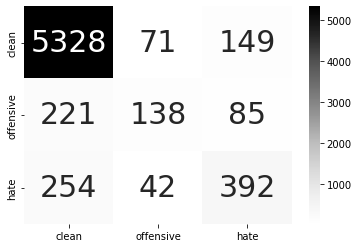

In [ ]:
# Bert4news
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, recall_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, BertTokenizer, BertForSequenceClassification

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

train_X, train_y = pre_process_features(X_train, y_train, tokenized=False, lowercased = False)
dev_X, dev_y = pre_process_features(X_dev, y_dev, tokenized=False, lowercased = False)
test_X, test_y = pre_process_features(X_test, y_test, tokenized=False, lowercased = False)
  
model = AutoModelForSequenceClassification.from_pretrained("NlpHUST/vibert4news-base-cased", num_labels = 3)
tokenizer = AutoTokenizer.from_pretrained("NlpHUST/vibert4news-base-cased",use_fast=False)

import torch

class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_encodings = tokenizer(train_X, truncation=True, padding=True, max_length=100)
dev_encodings = tokenizer(dev_X, truncation=True, padding=True, max_length=100)
test_encodings = tokenizer(test_X, truncation=True, padding=True, max_length=100)

train_dataset = BuildDataset(train_encodings, train_y)
dev_dataset = BuildDataset(dev_encodings, dev_y)
test_dataset = BuildDataset(test_encodings, test_y)

training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Colab Notebooks/ViHSD/transformer_model/bert4news-v8/',          
    num_train_epochs=2,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=16,   
    warmup_steps=500,                
    weight_decay=0.01,
    no_cuda=False,
    do_eval=True
)

trainer = Trainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=dev_dataset             
)

trainer.train()
trainer.save_model("/content/drive/MyDrive/Colab Notebooks/ViHSD/transformer_model/bert4news-v8/")

y_pred_classify = trainer.predict(test_dataset)

y_pred = np.argmax(y_pred_classify.predictions, axis=-1)
y_true = test_y

cf2 = confusion_matrix(y_true, y_pred)
print(cf2)

evaluation = f1_score(y_true, y_pred, average='micro')

print("F1 - micro: " + str(evaluation))

evaluation = f1_score(y_true, y_pred, average='macro')
print("F1 - macro: " + str(evaluation))

evaluation = accuracy_score(test_y, y_pred)
print("Accuracy: " + str(evaluation))

# Show out the confusion matrix
df_cm2 = pd.DataFrame(cf2, index = ["clean","offensive","hate"],
                  columns = ["clean","offensive","hate"])
plt.clf()
sn.heatmap(df_cm2, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})